In [9]:
import pickle
import scanpy as sc
import squidpy as sq
from util import *
from Algorithm.graph import *
from Algorithm.distribution import *

In [ ]:
ctrl_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_B = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_B_data.h5ad')
adata_C = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_C_data.h5ad')

F:\conda\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


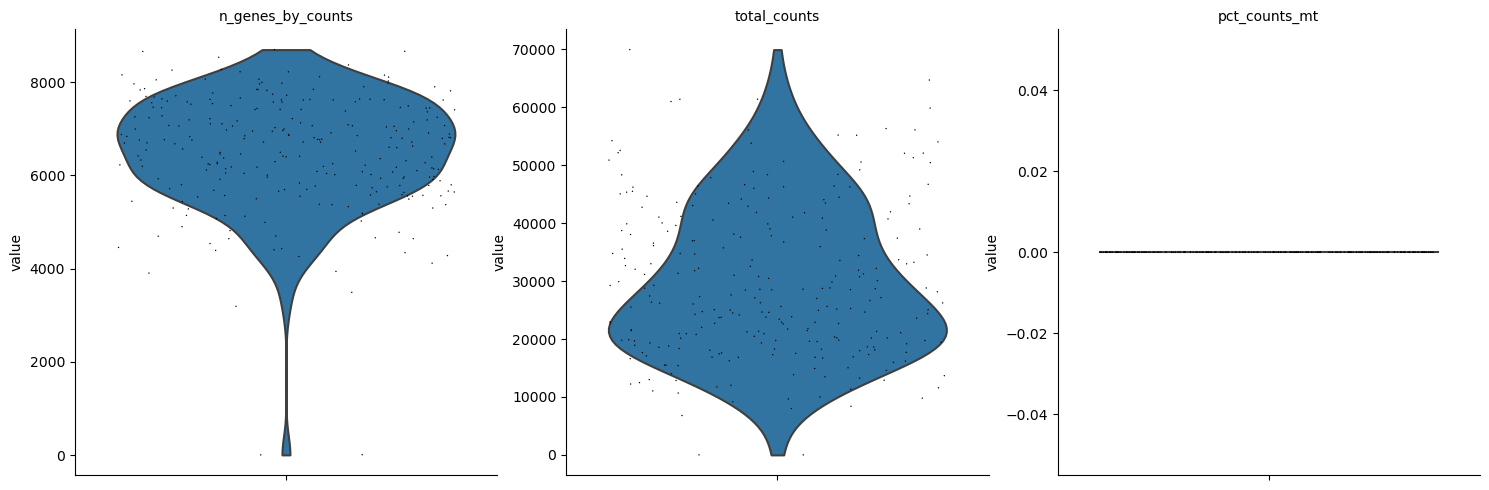

In [13]:
test = sc.read_h5ad('F://Rep11_MOB_ST.h5ad')
position_list = list(test.obs.index.str.split('x'))
arr = np.array(position_list, dtype=np.float32).reshape(len(position_list), 2)
test.obs['fig_x'] = arr[:,0] * 1000
test.obs['fig_y'] = arr[:,1] * 1000

h5_path = 'E://human/GSM4838131_Visium_Sample_A_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838131_Visium_Sample_A_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838133_Visium_Sample_C_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838133_Visium_Sample_C_tissue_positions_list.csv'

h5_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

adata = sc.read_10x_h5(h5_path)
add_spatial_position(adata, csv_path)
adata = test
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)

#sc.pp.filter_genes(adata, min_cells=2)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var_names_make_unique()

#adata = adata[adata.obs["pct_counts_mt"] < 8]
sc.pl.violin(adata,
             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pp.filter_genes(adata, min_cells=50)

In [ ]:
result = convolve(get_3d_matrix(adata), kernel=get_gaussian_kernel(size=5))
update_anndata(result, adata)

In [14]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [15]:
gene_list = adata.var[adata.var['highly_variable']==True].index
len(gene_list)

2206

In [313]:
paper = ['Rab3b','Necab2','Tspan7','Cdr1','Slc17a7','4933405L10Rik','Taf7l','Gna14','Olfr635','Pmepa1','Pcp4','Apc','Rbfox3','Penk','Frzb','Fabp7','Slc6a11','Apod','S100a5','Arhgap33','Cplx1','Trnp1','Marcks','Atp1b1','Vtn','Trak2','Igf1','Gabra1','Igfbp2','Lpar1','Omp','Kif5b','Sorbs1','Cck','Nr2f2','Scd1','Cpe','Aqp4','Doc2g','Slc1a2','Nrgn','Cdhr1','Mcf2l','Kctd12','Unc13c','Foxd3','Prokr2','Gng13','Kcnh3','Camk2b','Baiap2','Ccnd1','Gpsm1','Pbx1','Sepp1','Apoe','Tubb2b','Ncdn','Glul','Sash1','Ptgds','Sparcl1','Mbp','Nrsn1','Igfbp5','Ptn','Sfrp5']
gene_list = adata.var[adata.var['gene_ids'].isin(paper)].index
len(gene_list)

In [ ]:
gmm_dict = fit_gmms(adata, gene_list, n_comp=10, thread=4)
with open('gmm_dict', 'wb') as file:
    pickle.dump(gmm_dict, file)

In [8]:
gmm_dict.keys()

NameError: name 'gmm_dict' is not defined

In [8]:
arr = build_distance_array(gmm_dict)
with open('arr', 'wb') as file:
    pickle.dump(arr, file)

Processing: 100%|██████████| 2206/2206 [1:22:13<00:00,  2.24s/it]


In [6]:
with open('arr', 'rb') as file:
    arr = pickle.load(file)


In [7]:
with open('gmm_dict', 'rb') as file:
    gmm_dict = pickle.load(file)

FileNotFoundError: [WinError 2] 系统找不到指定的文件。

In [18]:
kmeans = cluster(arr, 10, 10)
df = map_labels(gmm_dict, kmeans)

In [2]:
df

NameError: name 'df' is not defined

In [ ]:
sc.pl.spatial(adata,
              size=2,
              spot_size=.5,
              color=list(df[df['labels']==1]['gene'][:15]))

In [ ]:
sc.pl.spatial(adata, 
              size=2,
              spot_size=300,
              color=['tbk1','ptpro','tcap', 'mt2'])